In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tfvmd.visualization.plotter import VMDVisualizer
from tfvmd.visualization.config import VisualizationConfig, FontConfig, LegendConfig, SaveConfig
from tfvmd.core.decomposition import TimeFrequencyVMD
from tfvmd.core.config import VMDConfig, BandwidthConfig
from ssqueezepy.experimental import scale_to_freq
from ssqueezepy import irfft, fftshift
from scipy.signal import istft
from scipy.ndimage import gaussian_filter
from matplotlib.gridspec import GridSpec

In [3]:
def single_irfft(result, vmd, t):
    mode_functions = np.array(result.mode_functions)
    time_indices = np.array(result.time_indices)
    center_frequencies = np.array(result.center_frequencies)
    Sx = np.squeeze(mode_functions[time_indices == t].T)
    Cf = np.squeeze(center_frequencies[time_indices == t])
    wn = vmd.config.window.reshape(-1,1)
    n_fft = vmd.config.n_fft
    wn[wn==0]=np.nan

    xwbuf = irfft(Sx, n=n_fft, axis=0).real
    if vmd_dme.config.modulated:
        xwbuf = fftshift(xwbuf, axes=0)
    xbuf = xwbuf/wn
    return Sx, xbuf, Cf

def visualize_sx(ax, Sx, fs):
    # Original time-frequency map
    Sx = np.abs(Sx)**2
    Sx[Sx==0] = np.nan
    ax.plot(Sx, '-')

    xtick = np.arange(0, Sx.shape[0], fs//16)
    xticklabel = xtick/(Sx_dme.shape[0]-1)*fs/2
    ax.set_xticks(xtick)
    ax.set_xticklabels(xticklabel.astype(int))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power ')

def visualize_xbuf(ax, xbuf, vmd, cf):
    n_fft = vmd.config.n_fft
    plt.plot(
        xbuf[n_fft//4:-n_fft//4]+cf.reshape(1,-1)*fs/16)


    xtick = np.arange(0, xbuf.shape[0]+1-2*vmd.config.n_fft//4, fs//16)
    xticklabel = np.array([-n_fft//4, -n_fft//8,0, n_fft//8, n_fft//4])/fs
    ytick = np.arange(0, fs//16+1, 8)
    yticklabel = np.arange(0, fs//16+1, 8)/(fs//16)*fs/2
    ax.set_xticks(xtick)
    ax.set_xticklabels(xticklabel)
    ax.set_yticks(ytick)
    ax.set_yticklabels(yticklabel.astype(int))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Center Frequency (Hz)')

In [4]:
def generate_random():
    np.random.seed(7)
    N = 1024
    fs = 512
    signal = np.random.randn(N)
    signal = scipy.stats.zscore(signal)*0.5
    return signal, fs

In [5]:
def main(signal, fs, method_band='adaptive', method_mode='dme', transform_type = 'stft', t_mode=[0,0.5,1]):
    # Configure bandwidth estimation
    config_bandw = BandwidthConfig(
        method=method_band,
        scale_factor=1.0,
        base_method='silverman',
        min_bandwidth=1e-6
    )

    # Configure VMD
    config_vmd = VMDConfig(
        num_channels=1,
        n_fft=fs//2,
        alpha=50,
        tol=1e-8,
        tau=0.00001,
        max_iterations=1000,
        modulated=True,
        rho_thresh=0.0,
        method=method_mode,
        keep_residual=False
    )

    # Initialize VMD
    vmd = TimeFrequencyVMD(config_vmd, config_bandw)
    
    # Transform signal to TF domain
    signal_expanded = signal.reshape(1, -1)
    tf_map, scale = vmd.transformer.transform(signal_expanded, transform_type=transform_type)
    
    if transform_type=='cwt' or transform_type=='ssq_cwt':
        scale = scale_to_freq(scale, 'gmw', len(signal), fs=fs)
    # Decompose signal
    result = vmd.decompose(tf_map, t_modes=t_mode)
    # result = vmd.generate_time_domain_modes(result, transform_type)
    return result,vmd,scale

In [6]:
addfontsize = 4
# You can also customize base font sizes and then scale them
config = VisualizationConfig(
    base_fonts=FontConfig(
        base_font=12+addfontsize,
        base_title=14+addfontsize,
        base_label=12+addfontsize,
        base_tick=12+addfontsize,
        base_legend=10+addfontsize
    ),
    font_scale=1.2,  # These base sizes will be scaled by 1.2
    # tf_legend=LegendConfig(
    #     location='upper left'
    # ),
    centers_legend=LegendConfig(
        location='upper right',
        framealpha=0.7
    ),
    signal_legend=LegendConfig(
        location=(0.6, -0.02),  # Lower right
        ncol=2,
        frameon=False  # No frame
    ),
    save_config=SaveConfig(
        format='svg',
        transparent=True  # Transparent background
    )
)
visualizer = VMDVisualizer(config)

In [7]:
signal, fs = generate_random()

In [8]:
result_dme, vmd_dme, scale_dme = main(signal, fs, method_band='percentile', method_mode='dme', transform_type='stft')

Selected decomposition method: dme


DME Processing: 100%|██████████| 1024/1024 [00:07<00:00, 137.08it/s]


In [9]:
Sx_dme, xbuf_dme, Cf_dme = single_irfft(result_dme, vmd_dme, fs)

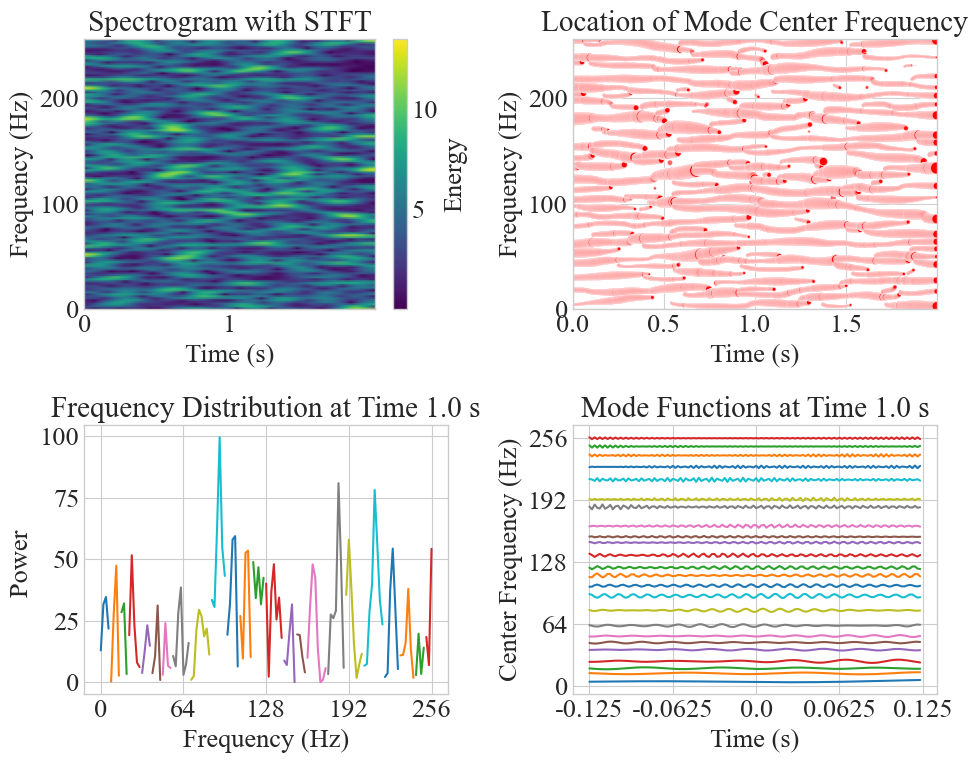

In [10]:
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result_dme, 512)
ax_tf.set_title('Spectrogram with STFT')

ax_tf = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf, result_dme, 512)
ax_tf.set_title('Location of Mode Center Frequency')

# Original time-frequency map
ax_tf = fig.add_subplot(gs[1, 0])
visualize_sx(ax_tf, Sx_dme, 512)
ax_tf.set_title(f'Frequency Distribution at Time {1024/fs/2} s')

# Center frequencies plot
ax_tf = fig.add_subplot(gs[1, 1])
visualize_xbuf(ax_tf, xbuf_dme, vmd_dme, Cf_dme)
ax_tf.set_title(f'Mode Functions at Time {1024/fs/2} s')

# Adjust layout
plt.tight_layout()
fig.savefig('result_A1.png', format='png', dpi=300)